In [1]:
"""
@author: efengler
"""
%pylab inline
import sys,os

Populating the interactive namespace from numpy and matplotlib


## the following cell can be used to recompile the c-extension

In [2]:
c = 'gcc -fPIC -shared -I/usr/include/python2.7/ -I/usr/local/lib/python2.7/dist-packages/numpy/core/include/numpy/ -lpython2.7 -O1 -march=native -mtune=native -o zbke_extension.so zbke_extension.c'
os.system(c)
# uncomment the upper line to recompile the c extension
# the included paths can vary with distro
# is the extension sucessfully compiled, a 0 is returned

0

In [3]:
import zbke_extension

# The following link contains the publication in which the zbke model was introduced
[ZBKE-model](https://pubs.acs.org/doi/abs/10.1021/j100131a030?journalCode=jpchax)

## Parameter

In [4]:
discr = 190
N     = 3
dt = 1e-4

# x,z component minimum and maximum
x_0   = 1e-4
x_E   = 1.2
z_0   = 2e-2
z_E   = 1.0

In [5]:
img = np.zeros((2,discr,discr))  #  0-dx, 1-dy
st  = np.random.RandomState(123)


arrow_time = 0.005

x_init = np.logspace(np.log10(x_0),np.log10(x_E),discr)
z_init = np.logspace(np.log10(z_0),np.log10(z_E),discr)
w_zero = np.zeros(N**2)
phi = 1e-3 #*np.ones(N)#5.3e-4* np.ones(N)
het = np.linspace(1.,1.1,N)




lc = []
x = np.ones(N)*x_0
z = np.ones(N)*z_0
zbke_extension.zbke_network(x,z,w_zero,het,phi,9.,dt) # transient
for i in range(9000):
    zbke_extension.zbke_network(x,z,w_zero,het,phi,50./9000.,dt) # transient
    lc.append( np.float32( [x[0].copy(),z[0].copy()] ) )

    

for i in range(discr):
    for j in range(discr):

        x = np.ones(N)*x_init[j]
        z = np.ones(N)*z_init[i]
        
        zbke_extension.zbke_network(x,z,w_zero,het,phi,arrow_time,dt)

        img[:,i,j] = x[0] - x_init[j] , z[0] - z_init[i]
        
    print "\rprocess: %04.2f"%(i/float(discr)),
img = np.nan_to_num( img )

process: 0.99 


In [6]:
def trafo(tmp,tmp_0,tmp_E,discr):
    tt = np.log10(tmp_0)
    try: idx =  int( (np.log10(tmp)-tt)/(np.log10(tmp_E)-tt)*discr ) # index in logspace
    except: idx=1
    return tmp_0 + float(idx)/discr *(tmp_E-tmp_0)

In [7]:
### search nullcline
dx_thresh , dz_thresh = .0003 , .00002
nullcline_discr = 3900
nc_x,nc_z = [[],[]],[[],[]]
fx =0.,0.
xlog = np.logspace(np.log10(x_0),np.log10(x_E),nullcline_discr)
zlog = np.logspace(np.log10(z_0),np.log10(z_E),nullcline_discr)
for i in range(nullcline_discr):
    #break
    xt = xlog[i]
    for j in range(nullcline_discr):

        zt = zlog[j]
        nx,nz = zbke_extension.zbke_nullclines( xt,zt,phi,het[0] )
        
        b1,b2 = abs(nz) < dz_thresh  , abs(nx) < dx_thresh
        if b1 and b2:
            fx= np.linspace(x_0,x_E,nullcline_discr)[i],np.linspace(z_0,z_E,nullcline_discr)[j]
        
        if b2:
            nc_x[0].append( trafo(xt,x_0,x_E,1000) )
            nc_x[1].append( trafo(zt,z_0,z_E,1000) )
            
        if b1:
            nc_z[0].append( trafo(xt,x_0,x_E,1000) )
            nc_z[1].append( trafo(zt,z_0,z_E,1000) )
            
    print "\rprocess: %04.2f"%(i/float(nullcline_discr)),
    
from scipy import interpolate
f_nx = interpolate.interp1d( nc_x[0], nc_x[1] )
f_nz = interpolate.interp1d( nc_z[0], nc_z[1] )

process: 0.00                                          


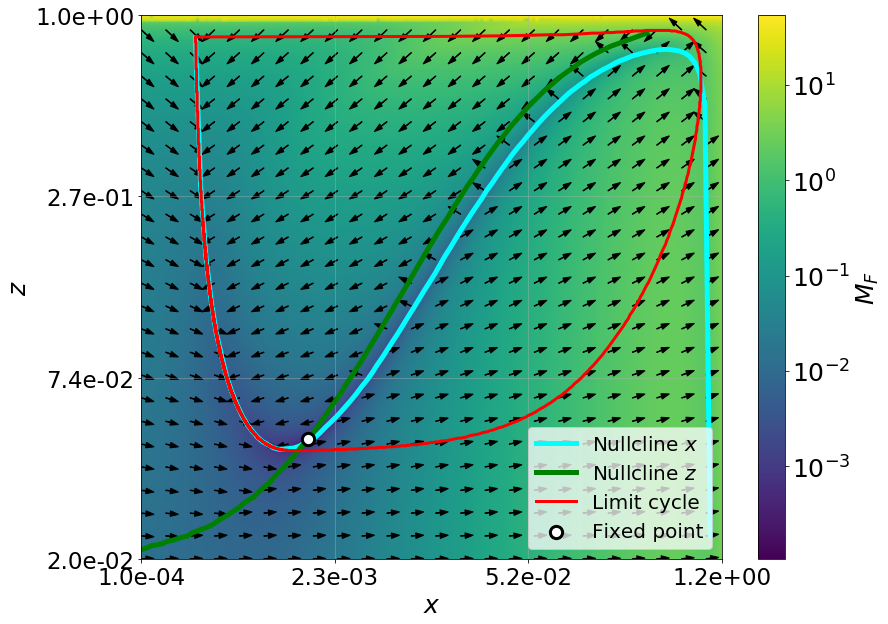

In [8]:
plt.figure( figsize=(13,10))

    
### arrows of direction field
arrow_len = 0.5  # [0,1] to the square of the next (in cartesian)
arrow_sparser = 8
arrows_0 = np.zeros((2,discr/arrow_sparser+1,discr/arrow_sparser+1)) # 0-x ,  1-y


dx_scale,dz_scale  =  arrow_len*(x_E-x_0)/(discr/arrow_sparser) , arrow_len*(z_E-z_0)/(discr/arrow_sparser)
headlen = 0.5*np.sqrt( dx_scale**2. + dz_scale**2. )
headwidth = .6*headlen

dz_max = 0.
for i in range(discr/arrow_sparser+1):
    for j in range(discr/arrow_sparser+1):
        ix,jx = i*arrow_sparser,j*arrow_sparser
        if ix>= discr : ix = discr-1
        if jx>= discr : jx = discr-1
        dz = abs( trafo( z_init[ix] + img[1,ix,jx] , z_0,z_E,1000 ) )
        if dz>dz_max : dz_max = dz

for i in range(discr/arrow_sparser+1):
    for j in range(discr/arrow_sparser+1):

        ix,jx = i*arrow_sparser,j*arrow_sparser
        
        if ix>= discr : ix = discr-1
        if jx>= discr : jx = discr-1
        
        arrows_0[:,i,j] = trafo(x_init[jx],x_0,x_E,1000) , trafo(z_init[ix],z_0,z_E,1000)

        tan_alpha = img[1,ix,jx] / img[0,ix,jx]
        
        if img[0,ix,jx] > 0 : dx =  dx_scale
        else :                dx = -dx_scale
        
        if img[1,ix,jx] > 0 : dz =   dz_scale
        else :                dz = - dz_scale
        
        dz *=  abs(trafo( z_init[ix] + img[1,ix,jx] , z_0,z_E,1000 )) / dz_max

        plt.arrow( arrows_0[0,i,j],arrows_0[1,i,j] , dx,dz, length_includes_head=True,
                   head_width=headwidth, head_length=headlen, fc='k')
        
        

        

### plot nullclines
xinterp = np.linspace( np.min(nc_x[0] ) , np.max(nc_x[0]), 100) 
plt.plot( xinterp, f_nx( xinterp ) ,color='cyan',label='Nullcline $x$',lw=5.)
xinterp = np.linspace( np.min(nc_z[0] ) , np.max(nc_z[0]), 100)
plt.plot( xinterp, f_nz( xinterp ) ,color='green',label='Nullcline $z$',lw=5.)




# plot limit cycle
lc = np.array(lc)
lc_trafo = lc.copy()
for i in range(len(lc)):
    lc_trafo[i,0] = trafo( lc_trafo[i,0] , x_0,x_E,1000)
    lc_trafo[i,1] = trafo( lc_trafo[i,1] , z_0,z_E,1000)
plt.plot( lc_trafo[:,0], lc_trafo[:,1] , lw=3.,color='r', label='Limit cycle')

plt.xlim(x_0,x_E)
plt.ylim(z_0,z_E)



### plot flow magnitude
from matplotlib.colors import LogNorm
magnitude = np.sqrt( (img[0]/arrow_time)**2. + (img[1]/arrow_time)**2. )[::-1]
plt.imshow(  magnitude,extent=[x_0,x_E,z_0,z_E],aspect='auto',interpolation='bilinear',norm=LogNorm())


### colorbar
pb = plt.colorbar( ticks=[1e-4,1e-3,1e-2,1e-1,1e0,1e1] )
pb.set_label('$M_F$',fontsize=25)
pb.ax.tick_params('y',labelsize=25)




### tick labels
axn = 4
xaxis = np.linspace(x_0,x_E,axn)
plt.xticks( xaxis ,  [ "%1.1e"%(np.logspace(np.log10(x_0),np.log10(x_E),axn)[xx]) for xx in range(axn) ]  )
zaxis = np.linspace(z_0,z_E,axn)
plt.yticks( zaxis ,  [ "%1.1e"%(np.logspace(np.log10(z_0),np.log10(z_E),axn)[zz]) for zz in range(axn) ]  )



### plotting fixed point
plt.scatter(  fx[0],fx[1],s= 150,color='white',linewidth=3,edgecolor='black',label='Fixed point',zorder=5)



### legend
plt.xlabel('$x$',fontsize=25)
plt.ylabel('$z$',fontsize=25)
plt.tick_params('both',labelsize=23)
leg=plt.legend(fontsize=20,loc='lower right')
leg.get_frame().set_alpha(0.75)
plt.grid(alpha=.5)
plt.show()